In [21]:
import numpy as np
import matplotlib.pyplot as plt

This note is about the Monte-Carol simulation for the expected wealth of a LP's position that
is withdrawn when the pool price reaches some upper and lower levels .

### Price dynamic
(model based)

In [34]:
def market_update( ln_S_m , p ,delta ):
    U = np.random.rand()
    if U < p :
        ln_S_m_new = ln_S_m + delta
    else:
        ln_S_m_new = ln_S_m - delta
    
    return ln_S_m_new

def pool_update( ln_S_p , ln_S_m_new , gamma ):
    
    if ln_S_m_new >  ln_S_p - np.log(gamma):
      
        ln_S_p_new =  ln_S_m_new + np.log(gamma) 
    
    elif ln_S_m_new < ln_S_p + np.log(gamma):
        
        ln_S_p_new =  ln_S_m_new - np.log(gamma)
    
    else:
        ln_S_p_new = ln_S_p
   
    return ln_S_p_new

def pool_process( T , p  , delta , gamma ):
    S_p_array = np.zeros(T+1)
    S_m_array = np.zeros(T+1)
    S_p_array[0]= 1
    S_m_array[0]=  1
    for i in range(T):
        S_m_array[i+1] = np.exp(market_update( np.log(S_m_array[i]) , p ,delta ))
        S_p_array[i+1] = np.exp(pool_update( np.log(S_p_array[i]) , np.log(S_m_array[i+1]) , gamma ))
    return S_p_array , S_m_array

#### Plot the price

C:\Users\std92\AppData\Local\Temp\ipykernel_9584\3506864384.py:32: RuntimeWarning: overflow encountered in exp
  S_p_array[i+1] = np.exp(pool_update( S_p_array[i] , S_m_array[i+1] , gamma ))
C:\Users\std92\AppData\Local\Temp\ipykernel_9584\3506864384.py:31: RuntimeWarning: overflow encountered in exp
  S_m_array[i+1] = np.exp(market_update( S_m_array[i] , p ,delta ))


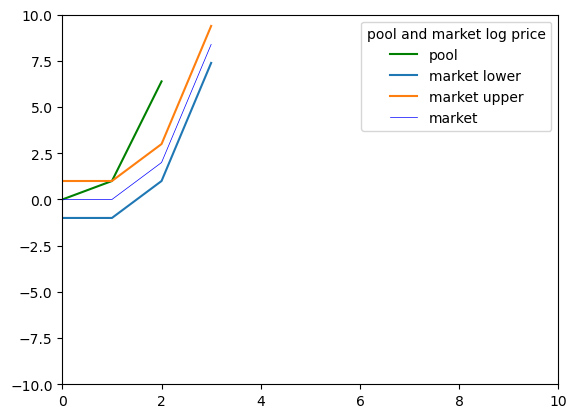

In [30]:
delta = 1
k=1
gamma = np.exp(-k*delta)

# Total run time should be as large as possible
T= 1000

S_p_array , S_m_array = pool_process( T , 0.6 , delta , gamma )


S_p_array , S_m_array = pool_process( T , 0.6 , delta , gamma )
T_array=np.arange(T+1)

plt.figure()
plt.plot(T_array, np.log(S_p_array) ,'g' , label='pool')
plt.plot(T_array, np.log(gamma*S_m_array) , label='market lower')
plt.plot(T_array, np.log(S_m_array*(gamma**-1)) , label='market upper' )
plt.plot(T_array, np.log(S_m_array) , 'b',linewidth=0.5 , label='market')
plt.legend(title="pool and market log price")

plt.xlim(0,10)
plt.ylim(-10,10)
plt.show()

### Position & asset value part
This part computes the asset value of the state . (model free)

Parameters:
* ```P_a``` : LP's lower price range  boundary
* ```P_b``` : LP's upper price range  boundary
* ```S_p``` : current pool price

Functions:
* ```position``` : returns a tuple of amount of X and Y asset for the given pool price and LP price range .
* ```asset_value``` :

In [5]:
def position(P_a,P_b,L,S_p):
    if S_p >= P_a and S_p <= P_b :    
        X = L * (np.sqrt(S_p) - np.sqrt(P_a) )
        Y = L * (1/np.sqrt(S_p) - 1/np.sqrt(P_b))
    elif S_p > P_b :
        X = L * (np.sqrt(P_b) - np.sqrt(P_a) )
        Y = 0
    elif S_p < P_a :
        X = 0
        Y = L * (1/np.sqrt(P_a) - 1/np.sqrt(P_b))
    return X,Y
position(10,100,5,2)

(0, 1.0811388300841898)

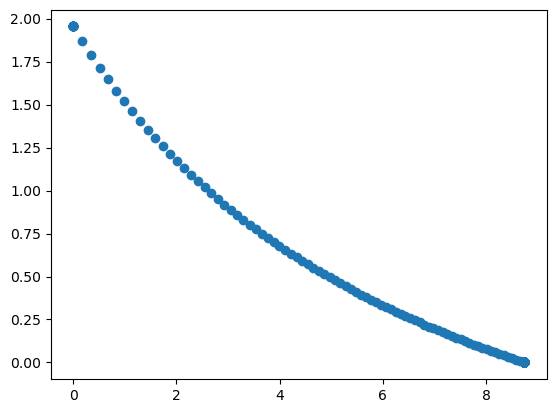

In [6]:
# An example of position curve 
X =np.array( [position(2,10,5,s/10 )[0] for s in range(1,1000)] )
Y = np.array( [position(2,10,5,s/10 )[1] for s in range(1,1000)] )
plt.scatter( X , Y )

In [13]:
def asset_value(P_a,P_b,L,S_p , S_m):
    return position(P_a,P_b,L,S_p)[0]+ S_m*position(P_a,P_b,L,S_p)[1]

### Fee collection part
(model free)

In [8]:
#retun the fee from the given price change
def fee_collecting( P_a,P_b , gamma ,  L , S_p_old , S_p_new , S_m_new ):
    A = max(S_p_old , P_a)
    B = min(S_p_old , P_b)
    fee = 0
    # fee from X asset (price up)
    if S_p_old < P_b and S_p_new > A  :
        fee = L*(1-gamma)/gamma *( np.sqrt( min( S_p_new , P_b) ) - np.sqrt( A ))
            
    # fee from Y asset (price down)        
    elif S_p_old > P_a and S_p_new < B :
        fee = L*(1-gamma)/gamma *S_m_new*( 1/np.sqrt( max( S_p_new , P_a) ) - 1/np.sqrt( B ))
            
    return fee


#compute the discounted fee earned at each moment for the given price path with finite length
def disc_fee_process(r,P_a,P_b , gamma ,  L , S_p_array , S_m_array) :
    # time 0 ~ T
    T = len(S_p_array) - 1
    F = np.zeros_like(S_p_array)
    t= 1
    # run from 1 ~ T
    while t >0 and t <= T:
        fee = fee_collecting( P_a , P_b , gamma ,  L , S_p_array[t-1] , S_p_array[t] , S_m_array[t] )
        F[t] = F[t-1] + np.exp(-r*t)*fee
        t = t+1
    return F     

### Total wealth 
(model free)

In [14]:
#stopped at a given timing tau
def disc_wealth_stopped(r ,P_a,P_b , gamma ,  Tau ,  L , S_p_array , S_m_array):
    S_p = S_p_array[Tau]
    S_m = S_m_array[Tau]
    
    fee_part = disc_fee_process(r,P_a,P_b , gamma , L , S_p_array[:Tau+1] , S_m_array[:Tau+1])[-1]
    asset_part = np.exp(-r*Tau)*asset_value(P_a,P_b,L, S_p , S_m)
    
    return  fee_part + asset_part 

### Stopping at the boundary
(model based)

In [10]:
def stop_bd_process(k , gamma , ln_P_l , ln_P_u , ln_S_p_ini , ln_S_m_ini , p):
    delta = -np.log(gamma)/k

    t = 0
    ln_S_p_array = np.array([ln_S_p_ini*delta])
    ln_S_m_array = np.array([ln_S_m_ini*delta])
    
    #touch the boundary then stopp (allow some numerical error due to the limitation)  
    while ln_S_p_array[t] <= ln_P_l*0.99*delta or ln_S_p_array[t] >= ln_P_u*0.99*delta :
                  
        ln_S_m_new = market_update( ln_S_m_array[t] , p , delta )
        ln_S_p_new = pool_update( ln_S_p_array[t] , ln_S_m_new , gamma )
        
        ln_S_p_array = np.append(ln_S_p_array , ln_S_p_new)
        ln_S_m_array = np.append(ln_S_m_array , ln_S_m_new)
        t = t+1
    return ln_S_p_array , ln_S_m_array , t

### Expected wealth (stop at boundary)
(model based)

In [11]:
gamma = 0.997
k=2         #delta = -ln(gamma)/k 
ln_Pa = -2  
ln_Pb =  5 
p =0.6
ln_Pl = -1   
ln_Pu =  10 
L = 1
r = 0

#compute the expected wealth(stopping at boundary) at given starting point 
def exp_wealth_bd(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , ln_Sp_ini , ln_Sm_ini , L ,gamma , r , p):
    delta = -np.log(gamma)/k 
    P_a, P_b  = np.exp( np.array([ln_Pa, ln_Pb ])*delta )
    data = np.zeros(10**5)
    
    for i in range(10**5):
        """if i% 1000 == 0:
            print(i/1000)"""
        ln_Sp_array , ln_Sm_array , Tau = stop_bd_process(k , gamma , ln_Pl , ln_Pu , ln_Sp_ini , ln_Sm_ini , p)
        S_p_array , S_m_array = np.exp( (ln_Sp_array , ln_Sm_array) )
        data[i] = disc_wealth_stopped(r ,P_a,P_b , gamma ,  Tau ,  L , S_p_array , S_m_array)
    return np.average(data)

In [ ]:
exp_wealth_bd(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , ln_Pu  , ln_Pu+k , L ,gamma , 0 , p)

The following is to compare with the result from Bellman equation

In [191]:
#compute the expected wealth at all left and right endpoints to compare with the result from Bellman equation
def exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma , r , p):
    N = ln_Pu - ln_Pl - 1
    V_0 = np.zeros(2*N+2)
    for n in range(2*N+2):
        print("index " , n)
        if n <= N :
            V_0[n] = exp_wealth_bd(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , n+ln_Pl , n+ln_Pl-k , L ,gamma , r , p)
        elif n >= N+1 :
            V_0[n] = exp_wealth_bd(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , n+ln_Pl-N , n-N+ln_Pl+k , L ,gamma , r , p)
    return V_0


index  0
index  1
index  2
index  3
index  4
index  5
index  6
index  7
index  8
index  9
index  10
index  11
index  12
index  13
index  14
index  15
index  16
index  17
index  18
index  19
index  20
index  21
index  0
index  1
index  2
index  3
index  4
index  5
index  6
index  7
index  8
index  9
index  10
index  11
index  12
index  13
index  14
index  15
index  16
index  17
index  18
index  19
index  20
index  21
index  0
index  1
index  2
index  3
index  4
index  5
index  6
index  7
index  8
index  9
index  10
index  11
index  12
index  13
index  14
index  15
index  16
index  17
index  18
index  19
index  20
index  21
index  0
index  1
index  2
index  3
index  4
index  5
index  6
index  7
index  8
index  9
index  10
index  11
index  12
index  13
index  14
index  15
index  16
index  17
index  18
index  19
index  20
index  21
index  0
index  1
index  2
index  3
index  4
index  5
index  6
index  7
index  8
index  9
index  10
index  11
index  12
index  13
index  14
index  15
index  16


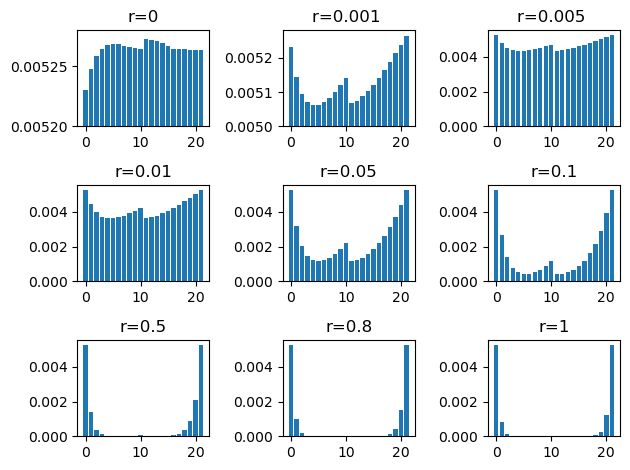

In [194]:
#result with different interest rate
N = ln_Pu - ln_Pl - 1
fig , ax =plt.subplots(3,3)
V_0 = exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma , 0 , p)
V_1 = exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma ,  0.001 , p)
V_2 = exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma ,  0.005 , p)
V_3 = exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma ,  0.01 , p)
V_4 = exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma ,  0.05 , p)
V_5 = exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma ,  0.1 , p)
V_6 = exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma ,  0.5 , p)
V_7 = exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma ,  0.8 , p)
V_8 = exp_wealth_bd_array(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma ,  1 , p)


N = ln_Pu - ln_Pl -1

ax[0,0].bar(np.arange(2*N+2), V_0  )
ax[0,0].set_title( "r=0")
ax[0,0].set_ylim(5.2*10**(-3),5.28*10**(-3))

ax[0,1].bar(np.arange(2*N+2),V_1  )
ax[0,1].set_title( "r=0.001 ")
ax[0,1].set_ylim(5*10**(-3),5.28*10**(-3))

ax[0,2].bar(np.arange(2*N+2),V_2  )
ax[0,2].set_title( "r=0.005 ")

ax[1,0].bar(np.arange(2*N+2),V_3 )
ax[1,0].set_title( "r=0.01")

ax[1,1].bar(np.arange(2*N+2),V_4 )
ax[1,1].set_title( "r=0.05")

ax[1,2].bar(np.arange(2*N+2),V_5 )
ax[1,2].set_title( "r=0.1")

ax[2,0].bar(np.arange(2*N+2),V_6 )
ax[2,0].set_title( "r=0.5")

ax[2,1].bar(np.arange(2*N+2),V_7 )
ax[2,1].set_title( "r=0.8")

ax[2,2].bar(np.arange(2*N+2),V_8 )
ax[2,2].set_title( "r=1")
plt.tight_layout()

### Cost normalization

In [198]:
V0 = exp_wealth_bd(k , ln_Pa, ln_Pb , ln_Pl , ln_Pu  , 0 , 0 , L ,gamma , r , p)
delta = -np.log(gamma)/k
P_a , P_b = np.exp(  np.array([ln_Pa, ln_Pb])*delta )
V0_normalized = V0 /position_value(P_a,P_b,L, 1, 1)

In [199]:
V0_normalized

1.002865528692053

In [197]:
gamma = 0.997
k=100         
delta = -np.log(gamma)/k 
#position range
ln_Pa = -5  
ln_Pb =  5 
L = 1
r=0.1
p=0.5

0.0014829499678218592

### Loss versus rebalancing (LVR)
In the following we introduce a rebalancing strategy $\{(X^R_n , Y^R_n)\}_{n \geq 0}$ that outperforms the LP's asset value : 
At the begin , the initial position is $(X^R_0 , Y^R_0) \equiv (X_0 , Y_0)$ (same as LP's initial
position) . Then we require the process   satisfying for all $n\geq 0$  :

1. risky asset replication : $Y^R_n = Y_n$
2. self-financing : $ e^{-r}V_{n+1} - V_n = Y^R_{n}( e^{-r}S_{n+1} - S_n) \quad$  where $V_n \equiv X^R_{n} + S_n Y^R_{n}$ is the portfolio value of the strategy .

In other words , this strategy maintains the same amount of risky asset $Y$ as LP by trading with the market and
it must be self-financing (in the discounted sense). Note that 
$$
\begin{align*}
e^{-n r}V_n &= V_0 + \sum^n_{m=1} Y_{m-1} (  e^{-mr }S_m - e^{-(m-1)r}S_{m-1}) \\
\Rightarrow 
X^R_n &= e^{n r } \big\{ X_0 + \sum^n_{m=1} Y_{m-1} (  e^{-mr }S_m - e^{-(m-1)r}S_{m-1}) \big\} - S_n Y_n  
\end{align*}
$$

It's not diffcult to show that the rebalancing strategy outperforms , i.e $e^{n r} V_n \geq e^{n r} W_n \equiv e^{n r} (X_n + S_n Y_n) $ , but the problem is that is such strategy really admissible ? ( $X^R_n \geq 0$ ?)  

Functions:
* ```position_R``` : return a tuple-array consists of the rebalancing position w.r.t the input pool price and market price paths .  

In [49]:
def position_R(r ,P_a,P_b , gamma ,  L , S_p_array , S_m_array):
    length = len(S_p_array)
    X_R = np.zeros(length)
    X_R[0] = position(P_a,P_b,L,S_p_array[0])[0]
    Y_R = np.array( [position(P_a,P_b,L,S_p_array[time])[1] for time in range(length)] )

    sum = 0
    for time in range(1,length):
        sum+= Y_R[time-1]*(np.exp(-time*r)*S_m_array[time] - np.exp(-(time-1)*r)*S_m_array[time-1])
        X_R[time] = np.exp(time*r)*( X_R[0] + sum ) - S_m_array[time] * Y_R[time]
    return X_R , Y_R

$$
X^R_n = e^{n r } \big\{ X_0 + \sum^n_{m=1} Y_{m-1} (  e^{-mr }S_m - e^{-(m-1)r}S_{m-1}) \big\} - S_n Y_n $$

In [57]:
gamma = 0.997
k=10
delta = -np.log(gamma)/k
p=0.5
T = 10**5
S_p_array , S_m_array = pool_process( T , p  , delta , gamma )

In [64]:

X = position_R(0.01 , P_a ,P_b , gamma ,  1 , S_p_array , S_m_array)[0]

C:\Users\std92\AppData\Local\Temp\ipykernel_9584\2054239785.py:10: RuntimeWarning: overflow encountered in exp
  X_R[time] = np.exp(time*r)*( X_R[0] + sum ) - S_m_array[time] * Y_R[time]


In [63]:
P_a = np.exp(-5*delta)
P_b = np.exp(5*delta)
P_a,P_b

(0.9984988733093293, 1.0015033834597085)

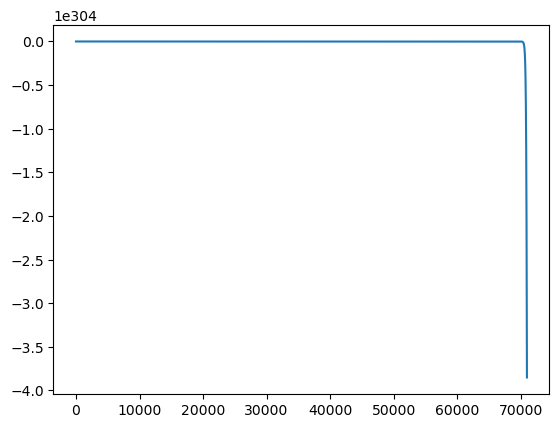

In [67]:
plt.plot(X)
#plt.ylim(-0.01,0.01)
#plt.xlim(0,1000)